In [1]:


from torchvision import datasets,transforms

In [2]:
import torch 
import syft as sy
import copy

hook = sy.TorchHook(torch)
from torch import nn,optim

W0621 15:04:34.292070 140190934955776 secure_random.py:22] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow (1.14.0). Fix this by compiling custom ops.
W0621 15:04:34.309285 140190934955776 deprecation_wrapper.py:119] From /home/venktesh/anaconda3/envs/pysyft/lib/python3.6/site-packages/tf_encrypted/session.py:28: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [3]:

import torch
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

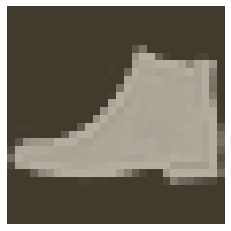

In [4]:

image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

In [5]:
bob = sy.VirtualWorker(hook, id ="bob")
alice = sy.VirtualWorker(hook, id="alice")

In [6]:
import math
import logging

import torch
from torch.utils.data import Dataset

logger = logging.getLogger(__name__)
def dataset_federate(dataset, workers):
    logger.info("Scanning and sending data to {}...".format(", ".join([w.id for w in workers])))

    data_size = math.ceil(len(dataset) / len(workers))

    datasets = []
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=data_size, drop_last=True)
    for dataset_idx, (data, targets) in enumerate(data_loader):
        worker = workers[dataset_idx % len(workers)]
        logger.debug("Sending data to worker %s", worker.id)
        data = data.send(worker)
        targets = targets.send(worker)
        datasets.append(sy.BaseDataset(data, targets))  # .send(worker)

    logger.debug("Done!")
    return sy.FederatedDataset(datasets)

In [7]:
federated_train_loader = sy.FederatedDataLoader(dataset_federate(trainset,(bob, alice)),
                                                batch_size=64, shuffle=True)

In [8]:
#buildng the network

from torch import nn 
model = nn.Sequential(
                    nn.Linear(784,128),
                    nn.ReLU(),
                    nn.Linear(128,64),
                    nn.ReLU(),
                    nn.Linear(64,10),
                    nn.LogSoftmax(dim=1)
                    )

In [9]:
#definign criterion and optimizer

from torch import  optim 
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.0005)

In [10]:

for epoch in range(10):
    model.train()
    for batch_idx, (data, target) in enumerate(federated_train_loader):
        data = data.view(data.shape[0], -1)
        model.send(data.location)
        output = model(data)
        data, target = data.to('cpu'), target.to('cpu')
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.get()
        if batch_idx % 30 == 0:
            loss = loss.get() 
            print('Train Epoch: {} Loss: {:.6f}'.format(
                epoch, loss.item()))
    model.eval()
    print('Epoch: ', epoch)
    total_correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(testloader):
        data = data.view(data.shape[0], -1)
        output = model(data)
        
        loss = criterion(output, target)
        print('Loss: ', loss.item())
        max_arg_output = torch.argmax(output, dim=1)
        total_correct += int(torch.sum(max_arg_output == target))
        total += data.shape[0]
    print('Testing data accuracy: {:.0%}'.format(total_correct/total))

Train Epoch: 0 Loss: 2.334021
Train Epoch: 0 Loss: 2.301412
Train Epoch: 0 Loss: 2.297607
Train Epoch: 0 Loss: 2.299713
Train Epoch: 0 Loss: 2.296465
Train Epoch: 0 Loss: 2.290740
Train Epoch: 0 Loss: 2.277173
Train Epoch: 0 Loss: 2.262392
Train Epoch: 0 Loss: 2.275093
Train Epoch: 0 Loss: 2.262860
Train Epoch: 0 Loss: 2.265549
Train Epoch: 0 Loss: 2.256385
Train Epoch: 0 Loss: 2.253033
Train Epoch: 0 Loss: 2.267847
Train Epoch: 0 Loss: 2.247274
Train Epoch: 0 Loss: 2.258145
Train Epoch: 0 Loss: 2.213878
Train Epoch: 0 Loss: 2.244611
Train Epoch: 0 Loss: 2.234027
Train Epoch: 0 Loss: 2.232936
Train Epoch: 0 Loss: 2.241218
Train Epoch: 0 Loss: 2.225300
Train Epoch: 0 Loss: 2.224937
Train Epoch: 0 Loss: 2.213945
Train Epoch: 0 Loss: 2.227190
Train Epoch: 0 Loss: 2.180004
Train Epoch: 0 Loss: 2.168017
Train Epoch: 0 Loss: 2.167094
Train Epoch: 0 Loss: 2.171616
Train Epoch: 0 Loss: 2.157797
Train Epoch: 0 Loss: 2.170491
Train Epoch: 0 Loss: 2.169739
Epoch:  0
Loss:  2.158106565475464
Loss:

Loss:  1.9314230680465698
Loss:  1.961931824684143
Loss:  1.9365421533584595
Loss:  1.9687604904174805
Loss:  1.9801018238067627
Loss:  1.978806972503662
Loss:  1.9213593006134033
Loss:  1.9091235399246216
Loss:  1.8836129903793335
Loss:  1.9327590465545654
Loss:  1.952704668045044
Loss:  1.9263843297958374
Loss:  1.9227991104125977
Loss:  1.9092568159103394
Loss:  1.9472177028656006
Loss:  1.940451741218567
Loss:  1.9796644449234009
Loss:  1.993282437324524
Loss:  1.9470020532608032
Loss:  1.91757333278656
Loss:  1.9259041547775269
Loss:  1.8927217721939087
Loss:  1.8389661312103271
Loss:  1.8476213216781616
Loss:  1.9643290042877197
Loss:  1.9313222169876099
Loss:  1.967725157737732
Loss:  1.9578741788864136
Loss:  1.9647985696792603
Loss:  1.8934926986694336
Loss:  1.9714323282241821
Loss:  1.954177737236023
Loss:  1.9395772218704224
Loss:  1.8839032649993896
Loss:  1.9733200073242188
Loss:  1.9092177152633667
Loss:  1.8626341819763184
Loss:  1.9174020290374756
Loss:  1.908115506172

Loss:  1.3682812452316284
Loss:  1.3600116968154907
Loss:  1.299446940422058
Loss:  1.2850004434585571
Loss:  1.4308342933654785
Loss:  1.4051584005355835
Loss:  1.354848027229309
Loss:  1.4663701057434082
Loss:  1.296506404876709
Loss:  1.361981749534607
Loss:  1.268383264541626
Loss:  1.3148895502090454
Loss:  1.3576604127883911
Loss:  1.3316420316696167
Loss:  1.251694917678833
Loss:  1.3847038745880127
Loss:  1.358306646347046
Loss:  1.3265732526779175
Loss:  1.3168174028396606
Loss:  1.3091094493865967
Loss:  1.2972437143325806
Loss:  1.3136992454528809
Loss:  1.546568512916565
Loss:  1.3411272764205933
Loss:  1.2672970294952393
Loss:  1.334514856338501
Loss:  1.363122582435608
Loss:  1.2262904644012451
Loss:  1.2581650018692017
Loss:  1.280037522315979
Loss:  1.4414751529693604
Loss:  1.3536362648010254
Loss:  1.3424617052078247
Loss:  1.3587799072265625
Loss:  1.3419653177261353
Loss:  1.3872630596160889
Loss:  1.32968270778656
Loss:  1.338807463645935
Loss:  1.3791239261627197


Train Epoch: 5 Loss: 1.274149
Train Epoch: 5 Loss: 1.211354
Train Epoch: 5 Loss: 1.078285
Train Epoch: 5 Loss: 1.144699
Train Epoch: 5 Loss: 1.109192
Train Epoch: 5 Loss: 0.992682
Train Epoch: 5 Loss: 0.993411
Train Epoch: 5 Loss: 1.237637
Train Epoch: 5 Loss: 1.094409
Train Epoch: 5 Loss: 1.198745
Train Epoch: 5 Loss: 1.008521
Train Epoch: 5 Loss: 1.134951
Train Epoch: 5 Loss: 1.049276
Train Epoch: 5 Loss: 1.060020
Train Epoch: 5 Loss: 1.222608
Train Epoch: 5 Loss: 1.038183
Train Epoch: 5 Loss: 1.069355
Train Epoch: 5 Loss: 1.008977
Train Epoch: 5 Loss: 1.042935
Train Epoch: 5 Loss: 1.096052
Train Epoch: 5 Loss: 0.983311
Train Epoch: 5 Loss: 1.134735
Train Epoch: 5 Loss: 1.052598
Train Epoch: 5 Loss: 1.084564
Train Epoch: 5 Loss: 1.106061
Train Epoch: 5 Loss: 0.932964
Train Epoch: 5 Loss: 0.972498
Train Epoch: 5 Loss: 1.080489
Train Epoch: 5 Loss: 0.997506
Train Epoch: 5 Loss: 1.109815
Train Epoch: 5 Loss: 0.942182
Train Epoch: 5 Loss: 0.933815
Epoch:  5
Loss:  0.9779365062713623
Loss

Loss:  0.8733068108558655
Loss:  0.868728518486023
Loss:  0.8699883222579956
Loss:  0.879367470741272
Loss:  0.8954070806503296
Loss:  0.9867135286331177
Loss:  0.8090047836303711
Loss:  0.8465895056724548
Loss:  0.8966426253318787
Loss:  0.7453280687332153
Loss:  0.9169443845748901
Loss:  0.8683233857154846
Loss:  0.9493838548660278
Loss:  0.883435070514679
Loss:  1.092605710029602
Loss:  1.0410104990005493
Loss:  0.9090010523796082
Loss:  1.0307209491729736
Loss:  1.0857439041137695
Loss:  0.8460127115249634
Loss:  1.025457501411438
Loss:  0.9008001089096069
Loss:  0.9233028292655945
Loss:  0.9659305810928345
Loss:  0.8858029246330261
Loss:  1.0356545448303223
Loss:  0.9525965452194214
Loss:  0.9247839450836182
Loss:  0.9374855756759644
Loss:  0.9349952936172485
Loss:  0.946402370929718
Loss:  0.9975140690803528
Loss:  0.9902721047401428
Loss:  1.0225012302398682
Loss:  0.9519771933555603
Loss:  0.8056424260139465
Loss:  0.8564870953559875
Loss:  0.9974485039710999
Loss:  1.047667264

Loss:  0.6235313415527344
Loss:  0.9558982849121094
Loss:  0.8261184096336365
Loss:  0.6905320882797241
Loss:  0.9263976216316223
Loss:  1.058290719985962
Loss:  0.7469702363014221
Loss:  0.833731472492218
Loss:  0.7887392640113831
Loss:  0.673613429069519
Loss:  0.7600741982460022
Loss:  0.7755407691001892
Loss:  0.6899694204330444
Loss:  0.8910011053085327
Loss:  0.9317919611930847
Loss:  0.9199662804603577
Loss:  0.7174293994903564
Loss:  0.7155146598815918
Loss:  0.8300571441650391
Loss:  0.9073231816291809
Loss:  0.8930461406707764
Loss:  0.8474515676498413
Loss:  0.8414669632911682
Loss:  0.7325295805931091
Loss:  0.8622193336486816
Loss:  0.9186911582946777
Loss:  0.8631566762924194
Loss:  0.83653324842453
Loss:  0.6008003354072571
Loss:  0.7740240097045898
Loss:  0.9818359017372131
Loss:  0.6498076915740967
Loss:  0.7607444524765015
Loss:  0.8308331966400146
Loss:  0.8326109647750854
Loss:  0.957394540309906
Loss:  0.8963180780410767
Loss:  0.7693755626678467
Loss:  0.747962176